# 0. Import Moduls

In [130]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T
from torchsummary import summary


In [131]:
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# 1.  Set Parameters

In [132]:
IMG_SIZE = 480
THRESHOLD = 0.95

# 2. Load Model

In [133]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval().cpu()

In [134]:
model.parameters

<bound method Module.parameters of KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256

# 3. Image Process

In [135]:
def resize_img(img_path):
    img = Image.open(img_path)
    img = img.resize((IMG_SIZE, int(img.height*IMG_SIZE/img.width)))
    return img

def draw_img(img, figsize=(12,12)):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    plt.yticks([])
    plt.xticks([])
    return fig, ax

## 3-1. Resize

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14ee435d0>)

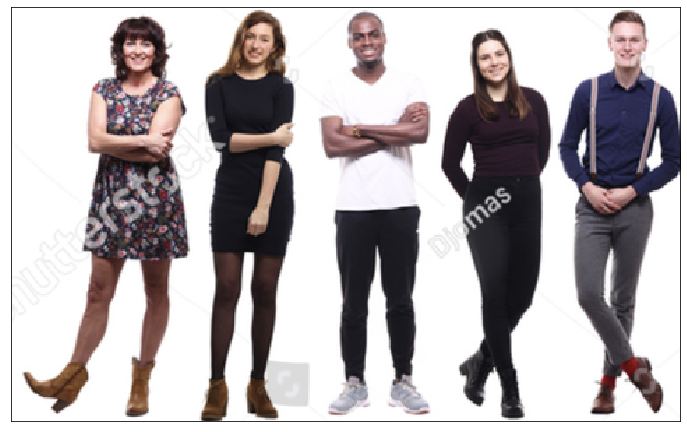

In [144]:
img = resize_img('imgs/fig1.png')
draw_img(img)

## 3-2. Image to Tensor
* **T.ToTensor():** Converts the image to type torch. Tensor and have have values between [0, 1]

In [145]:
trf = T.Compose([T.ToTensor()])
input_img = trf(img)[:3,:,:]
input_img.shape

torch.Size([3, 297, 480])

# 4. Use Model

## 4-1. test model and get outs

In [146]:
out = model([input_img])[0]
print(out.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


* **boxes** (Tensor[N, 4]): the ground-truth boxes in [x0, y0, x1, y1] format, with values between 0 and H and 0 and W
* **labels** (Tensor[N]): the class label for each ground-truth box
* **keypoints** (Tensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible

## 4-2. draw results

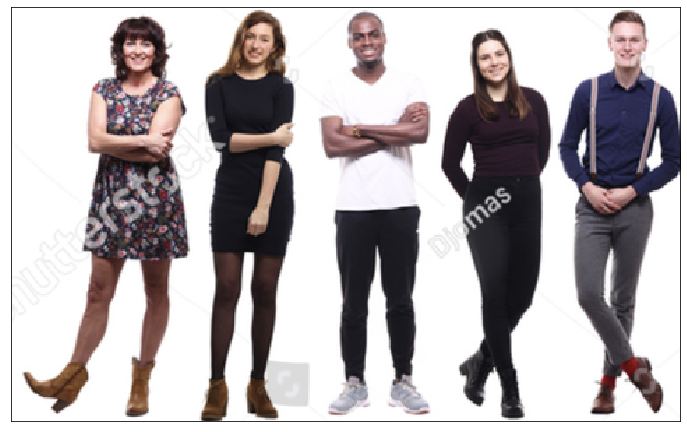

In [150]:
fig, ax=draw_img(img)

def draw_line(points):
    codes=[Path.MOVETO, Path.LINETO, Path.LINETO]
    path = Path(points, codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='orange')
    ax.add_patch(line)

for box, score, keypoint in zip(out['boxes'], out['scores'], out['keypoints']):

    box = box.detach().numpy()
    score = score.detach().numpy()
    keypoint=keypoint.detach().numpy()[:,:2]

    if score < THRESHOLD: continue

    x0,y0 = box[0],box[1]
    w, h = box[2]-box[0], box[3]-box[1]

    rect = patches.Rectangle((x0,y0),w,h, linewidth=2, edgecolor='dodgerblue', facecolor='none')
    ax.add_patch(rect)

    for k in keypoint:
        circle = patches.Circle((k[0],k[1]), radius=1.5, facecolor='orangered')
        ax.add_patch(circle)

    draw_line(keypoint[5:10:2])
    draw_line(keypoint[6:11:2])
    draw_line(keypoint[11:16:2])
    draw_line(keypoint[12:17:2])

plt.show()